This notebook addresses the question, "Can we represent a molecule as a graph via a 1D column vector or a 2D matrix of fixed length, with maximum number of atoms n_rows?" Then, can we use this representation to learn neural fingerprints? E.g., can we make an aromatic ring detector? 

Scheme:
feature_matrix = X
for each ligand:
    choose a central atom. this can be the atom (node) that minimizes distance to furthest heavy atom in graph.
    set first row of X to be this central atom
    set next four rows to be the atoms bonded to that centrl atom
        set zeros for rows where row ind > n_bonds of atom
    for each of those atoms:
        repeat. find their neighbors. add to matrix.

algorithm: breadth-first search:
1. create networkx graph based on molecule
2. find "central" atom (different strategies)
3. define atom matrix of size (1+4+4*3^(L-1)) x (n_features_per_atom)
4. start atom queue q
5. central_atom.layer = 0; central_atom.row_idx = 0;
6. q.enqueue(central_atom)
7. define adjacency matrix of size (1+4+4*3^(L-1)) x 4

def get_row_idx(curr_layer, prev_row_idx, curr_neighbor_idx):
    if curr_layer == 0:
        return(0)
    if curr_layer == 1:
        row_idx = 1 + curr_neighbor_idx
    if layer == 2:
        last_max = 5
        row_idx = last_max + (3*(prev_row_idx-last_max)) + curr_neighbor_idx
    if layer > 2:
        last_max = 5 + 4*3^(curr_layer-2) 
        row_idx = last_max + 3*(prev_row_idx-last_max) + curr_neighbor_idx
    return(row_idx)
    

while q.is_not_empty():
    a = q.dequeue()
    a.visited = True
    for n_idx, n in enumerate(a.neighbors()):
        if not n.visited:
            row_idx = c
            n.layer = a.layer + 1
            row_idx = get_row_idx(n.layer, a.row_idx, n_idx)
            n.row_idx = row_idx
            adj_matrix[a.row_idx][n_idx] = n.row_idx
            atom_matrix[row_idx][elem_to_idx[n.elem]] = 1

input_matrix = tf.concat([atom_matrix, atom_matrix[adj_matrix[:,0]], atom_matrix[adj_matrix[:,1]], atom_matrix[adj_matrix[:,2]], atom_matrix[adj_matrix[:,3]]

neural net:
h1 = relu([tf.zeros([n_features_per_atom, 4]) * input_matrix + bias))
h1_conc = tf.concat([h1, h1[adj_matrix[:,0], ..., h1[adj_matrix[:,3])

repeat h1 to get h2


dihedral predictor pseudocode:

get bonds for molecule
create networkx graph out of molecule (use atom indices)

for each edge:
   for neighbor_i in atom_i.neighbors():
       if neighbor_i == atom_j: continue
       for neighbor_j in atom_j.neighbors():
           if neighbor_j == atom_i: continue
           dihedrals.append((neighbor_i, atom_i, neighbor_j, atom_j))
           check to make sure (atom_j, neighbor_j, atom_i, neighbor_i)) not already in list

for dihedral in dihedrals:
    angle =  rdMolTransforms.GetDihedralDeg(c, 0,1,2,3)


In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolTransforms
import os
import fnmatch
import numpy as np
import deepchem as dc
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GMM


In [3]:
def get_torsions_angles(mol):
    torsion_tuples = []
    for bond in mol.GetBonds():
        atom_i = bond.GetBeginAtom()
        atom_j = bond.GetEndAtom()
        if atom_i.IsInRing() or atom_j.IsInRing():
            continue
        for neighbor_i in atom_i.GetNeighbors():
            if neighbor_i.GetIdx() == atom_j.GetIdx():
                continue
            
            for neighbor_j in atom_j.GetNeighbors():
                if neighbor_j.GetIdx() == atom_i.GetIdx():
                    continue
                torsion_tuple = (neighbor_i.GetIdx(), atom_i.GetIdx(), atom_j.GetIdx(), neighbor_j.GetIdx())
                reverse_torsion_tuple = (neighbor_j.GetIdx(), atom_j.GetIdx(), atom_i.GetIdx(), neighbor_i.GetIdx())
                if torsion_tuple not in torsion_tuples and reverse_torsion_tuple not in torsion_tuples:
                    torsion_tuples.append(torsion_tuple)
    c = mol.GetConformer(0)
    torsions = []
    torsion_matrix = np.zeros((250,1))
    torsion_indices = np.zeros((250,200,4)).astype(np.uint8)
    for i, torsion_tuple in enumerate(torsion_tuples):
        torsion_matrix[i] = np.abs(rdMolTransforms.GetDihedralRad(c, *torsion_tuple))
        torsion_indices[i][torsion_tuple[0]][0] = 1
        torsion_indices[i][torsion_tuple[1]][1] = 1
        torsion_indices[i][torsion_tuple[2]][2] = 1
        torsion_indices[i][torsion_tuple[3]][3] = 1
    return((torsion_indices, csr_matrix(torsion_matrix)))
                

In [4]:
def featurize_mols(mol_files):
    featurizer = AdjacencyFingerprint(max_n_atoms=200)
    features = []
    for mol_file in mol_files:
        mol = Chem.MolFromMol2File(mol_file)
        if mol is None:
            features.append(None)
            continue
        torsions = get_torsions_angles(mol)
        graph_feat = featurizer.featurize([mol])[0]
        features.append((mol_file, torsions, graph_feat))
    return(features)

In [5]:
from deepchem.feat.graph_features import ConvMolFeaturizer
from deepchem.feat.adjacency_fingerprints import AdjacencyFingerprint

In [6]:
import pickle
feature_file = "./dihedral_features_pdbbind.pkl"
if not os.path.exists(feature_file):
#if 1== 1:
    pdbbind_dir = "/home/evan/Documents/deep_docking/datasets/v2015/"
    def find_files(directory, pattern):
        for root, dirs, files in os.walk(directory):
            for basename in files:
                if fnmatch.fnmatch(basename, pattern):
                    filename = os.path.join(root, basename)
                    yield filename
    ligand_files = [f for f in find_files(pdbbind_dir, "*ligand.mol2")]
    features = featurize_mols(ligand_files)
    with open(feature_file, "wb") as f:
        pickle.dump(features, f, protocol=2)
else:
    with open(feature_file, "rb") as f:
        features = pickle.load(f)

In [7]:
features = [f for f in features if f is not None and len(np.where(f[1][1].toarray() == 0)[0]) < 250]

In [8]:
len(features)

7675

In [67]:
import tensorflow as tf
alpha = 0.1
n_layers = 2
S = 1
B = 200
L_list = [50, 50, 50, 50]
p = 75

x = tf.placeholder(tf.float32, shape=[S, B, p])

non_zero_inds = tf.placeholder(tf.int32, shape=[None, S*250])

adj_matrix = tf.placeholder(tf.float32, shape=[S, B, B])
dihed_indices = tf.placeholder(tf.float32, shape=[S, 250, B, 4])

label_placeholder = tf.placeholder(
    dtype='float32', shape=[S*250], name="label_placeholder")

phase = tf.placeholder(dtype='bool', name='phase')

z = tf.placeholder(tf.float32,
                          [None, 200, 75], name='z')

z_ini = tf.placeholder(tf.float32,
                          [None, 200, 75], name='z_ini')

ones_like = tf.placeholder(tf.float32, shape=[None,1])
zeros_like = tf.placeholder(tf.float32, shape=[None,1])


In [68]:
#DISCRIMINATOR

D_W_list = [None for i in range(n_layers)]
D_b_list = [None for i in range(n_layers)]
D_h_list = [None for i in range(n_layers)]



for layer_idx in range(n_layers):
    if layer_idx == 0:
      L_in = p
      L_out = L_list[0]
      atom_matrix = x
    else:
      L_in = L_list[layer_idx-1]
      L_out = L_list[layer_idx]
      atom_matrix = D_h_list[layer_idx-1]

    D_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="D_W_list%d" %layer_idx)
    D_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
D_W2 = tf.Variable(tf.truncated_normal([L_list[-1]*4+1, 100]))
D_b2 = tf.Variable(tf.zeros([1, 100]))

D_W3 = tf.Variable(tf.truncated_normal([100, 1]))
D_b3 = tf.Variable(tf.zeros([1, 1]))

D_W4 = tf.Variable(tf.truncated_normal([1, 10]))
D_b4 = tf.Variable(tf.zeros([1, 10]))

D_W5 = tf.Variable(tf.truncated_normal([10, 1]))
D_b5 = tf.Variable(tf.zeros([1, 1]))

def adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, is_training=True):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix, name="adj_conv1")
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W) + b
    h = tf.maximum(alpha*h, h)
    
    h = tf.reshape(h, (S, B, L_out))
    h = tf.contrib.layers.batch_norm(h, 
                                        center=True, scale=True, 
                                        is_training=is_training)

    return(h)

def discriminator(angles, is_training=True):
    for layer_idx in range(n_layers):
        if layer_idx == 0:
          L_in = p
          L_out = L_list[0]
          atom_matrix = x
        else:
          L_in = L_list[layer_idx-1]
          L_out = L_list[layer_idx]
          atom_matrix = D_h_list[layer_idx-1]
        
        D_h_list[layer_idx] = adjacency_conv_layer(atom_matrix, D_W_list[layer_idx], D_b_list[layer_idx], L_in, L_out, layer_idx)

    L_final = L_list[n_layers-1]
    h_final = tf.reshape(D_h_list[layer_idx], (S, B, L_final))

    #add dihedral regressor layers

    d0 = []
    for i in range(0, S):
        mol_tuple = []
        for j in range(0, 4):
          entry = h_final[i]
          indices = dihed_indices[i][:,:,j]
          atom_list = tf.matmul(indices, entry, name="disc1")
          atom_list = tf.reshape(atom_list, (250, L_final))
          mol_tuple.append(atom_list)
        mol_tuple = tf.reshape(tf.stack(mol_tuple, axis=1), (250, L_final*4))
        d0.append(mol_tuple)

    d0 = tf.concat(d0, axis=0)
    d0 = tf.concat([d0, tf.reshape(angles, (-1,1))], axis=1)
    d0 = tf.matmul(tf.cast(non_zero_inds, tf.float32), d0)


    d2 = tf.matmul(d0, D_W2, name="disc2") + D_b2
    d2 = tf.maximum(d2, alpha*d2)

    #d2 = tf.contrib.layers.batch_norm(d2, 
    #                                    center=True, scale=True, 
    #                                    is_training=is_training)
    
    d3 = tf.matmul(d2, D_W3, name="disc3") + D_b3
    d3 = tf.maximum(d3, alpha*d3)
    
    #d3 = tf.nn.tanh(d3)

    #d3 = tf.contrib.layers.batch_norm(d3, 
    #                                    center=True, scale=True, 
    #                                    is_training=is_training)
    
                                                                                                                                                               
    d4 = tf.matmul(d3, D_W4, name="disc3") + D_b4
    
    D_logit = tf.matmul(d4, D_W5, name="disc4") + D_b5
    
    D_prob = tf.nn.sigmoid(D_logit)
    return(D_prob, D_logit)



In [69]:
def atan2(y, x, epsilon=1.0e-12):
  # Add a small number to all zeros, to avoid division by zero:
  x = tf.where(tf.equal(x, 0.0), x+epsilon, x)
  y = tf.where(tf.equal(y, 0.0), y+epsilon, y)

  angle = tf.where(tf.greater(x,0.0), tf.atan(y/x), tf.zeros_like(x))
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.greater_equal(y,0.0)), tf.atan(y/x) + np.pi, angle)
  angle = tf.where(tf.logical_and(tf.less(x,0.0),  tf.less(y,0.0)), tf.atan(y/x) - np.pi, angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.greater(y,0.0)), 0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.less(y,0.0)), -0.5*np.pi * tf.ones_like(x), angle)
  angle = tf.where(tf.logical_and(tf.equal(x,0.0), tf.equal(y,0.0)), tf.zeros_like(x), angle)
  return angle

#GENERATOR

G_W_list = [None for i in range(n_layers)]
G_b_list = [None for i in range(n_layers)]
G_h_list = [None for i in range(n_layers)]


for layer_idx in range(n_layers):
    if layer_idx == 0:
      L_in = p
      L_out = L_list[0]
      atom_matrix = x
    else:
      L_in = L_list[layer_idx-1]
      L_out = L_list[layer_idx]
      atom_matrix = G_h_list[layer_idx-1]

    G_W_list[layer_idx] = tf.Variable(tf.truncated_normal([L_in, L_out], seed=2017), name="G_W_list%d" %layer_idx)
    G_b_list[layer_idx] = tf.Variable(tf.zeros([1, L_out]))

    
G_W2 = tf.Variable(tf.truncated_normal([L_list[-1]*4, 100]))
G_b2 = tf.Variable(tf.zeros([1, 100]))

G_W3 = tf.Variable(tf.truncated_normal([100, 100]))
G_b3 = tf.Variable(tf.zeros([1, 100]))

G_W4 = tf.Variable(tf.truncated_normal([100, 1]))
G_b4 = tf.Variable(tf.zeros([1, 1]))


def gen_adjacency_conv_layer(atom_matrix, W, b, L_in, L_out, layer_idx, z, is_training):
    print("layer_idx: %d" %(layer_idx))
    h = tf.matmul(adj_matrix, atom_matrix, name="gen0_%d" %layer_idx)
    h = tf.reshape(h, shape=(S*B, L_in))

    h = tf.matmul(h, W, name="gen1") + b
    h = tf.maximum(alpha*h, h)

    
    h = tf.reshape(h, (S, B, L_out))
    #h = tf.contrib.layers.batch_norm(h, 
    #                                    center=True, scale=True, 
    #                                    is_training=is_training)

    return(h)

def generator(z, is_training=True):
    for layer_idx in range(n_layers):
        if layer_idx == 0:
          L_in = p
          L_out = L_list[0]
          atom_matrix = tf.add(x, z)
        else:
          L_in = L_list[layer_idx-1]
          L_out = L_list[layer_idx]
          atom_matrix = G_h_list[layer_idx-1]
        
        G_h_list[layer_idx] = gen_adjacency_conv_layer(atom_matrix, G_W_list[layer_idx], G_b_list[layer_idx], L_in, L_out, layer_idx, z, is_training)

    L_final = L_list[n_layers-1]
    g_h_final = tf.reshape(G_h_list[layer_idx], (S, B, L_final))

    #add dihedral regressor layers

    g_d0 = []
    for i in range(0, S):
        mol_tuple = []
        for j in range(0, 4):
          entry = g_h_final[i]
          indices = dihed_indices[i][:,:,j]
          atom_list = tf.matmul(indices, entry, name='gen2')
          atom_list = tf.reshape(atom_list, (250, L_final))
          mol_tuple.append(atom_list)
        mol_tuple = tf.reshape(tf.stack(mol_tuple, axis=1), (250, L_final*4))
        g_d0.append(mol_tuple)

    g_d0 = tf.concat(g_d0, axis=0)
    
    g_d2 = tf.matmul(g_d0, G_W2, name='gen3') + G_b2
    g_d2 = tf.maximum(alpha*g_d2, g_d2)

    
    #g_d2 = tf.contrib.layers.batch_norm(g_d2, 
    #                                    center=True, scale=True, 
    #                                    is_training=is_training)
    
    g_d3 = tf.matmul(g_d2, G_W3) + G_b3
    g_d3 = tf.nn.tanh(g_d3)

    #g_d3 = tf.contrib.layers.batch_norm(g_d3, 
    #                                    center=True, scale=True, 
    #                                    is_training=is_training)
                                                                                                                                                               
    g_d4 = tf.matmul(g_d3, G_W4) + G_b4
    
    #output = g_d4
    d3_cos = tf.cos(g_d4)
    d3_sin = tf.sin(g_d4)
    output = tf.abs(atan2(d3_sin, d3_cos))
    
    G_logit = tf.nn.sigmoid(output)

    return(output, G_logit)



In [70]:
theta_D = [D_W_list[0], D_W_list[1], D_W2, D_W3, D_W4, D_W5, D_b_list[0], D_b_list[1], D_b2, D_b3, D_b4, D_b5]

theta_G = [G_W_list[0], G_W_list[1], G_W2, G_W3, G_W4, G_b_list[0], G_b_list[1], G_b2, G_b3, G_b4]

In [71]:
gmm = GMM(2, n_iter=1., covariance_type="spherical")

gmm.means_ = np.array([[-10], [10]])
gmm.covars_ = np.array([[0.0001], [0.0001]])

def construct_feed_dict(X, start=None,
                      stop=None, y=None,
                      keep_prob=1.0, train=False):
    if start is None:
      start = 0
      stop = len(X)

    adj = [X[idx][2][0].toarray().astype(np.float32) for idx in range(start, stop)]
    A_batch = [X[idx][2][1].toarray() for idx in range(start, stop)]
    D_batch = [X[idx][1][0] for idx in range(start, stop)]
    y_batch = [X[idx][1][1].toarray() for idx in range(start, stop)]

    y_batch = np.squeeze(np.concatenate(y_batch))
    non_zero_batch = np.where(y_batch != 0.)[0]
    
    ones_batch = np.random.uniform(0.7, 1.2, size=(len(non_zero_batch),1))
    zeros_batch = np.random.uniform(0., 0.3, size=(len(non_zero_batch),1))

    #y_batch = gmm.sample(len(y_batch))
    
    #y_batch = y_batch + np.random.normal(0, 0.1, size=(len(y_batch)))
    
    #y_batch = np.squeeze(gmm.sample(len(y_batch)))
    
    #adj = [np.random.uniform(-1., 1., size=a.shape) for a in adj]
    #A_batch = [np.random.uniform(-1., 1., size=a.shape) for a in A_batch]
    #D_batch = [np.random.uniform(-1., 1., size=a.shape) for a in D_batch]


    onehotter = OneHotEncoder(n_values = S*X[0][1][1].shape[0])
    non_zero_onehot = onehotter.fit_transform(non_zero_batch).toarray().reshape((len(non_zero_batch),S*X[0][1][1].shape[0]))
    
    z_batch = np.zeros((S, adj[0].shape[0], 75))
    #z_batch = np.random.uniform(-0.00001, 0.00001, size=(S, adj[0].shape[0],75))
    #y_batch = np.random.random(size=(S*250))
    
    feed_dict = {x: A_batch,
                 adj_matrix: adj,
                 phase: train,
                 label_placeholder: y_batch,
                 non_zero_inds: non_zero_onehot,
                 dihed_indices: D_batch,
                 z:z_batch,
                 ones_like: ones_batch,
                 zeros_like: zeros_batch
                }
    return(feed_dict)



In [74]:
G_pred, G_pred_logit = generator(z, is_training=False)
G_sample, G_sample_logit = generator(z, is_training=True)

D_real, D_logit_real = discriminator(label_placeholder)
D_fake, D_logit_fake = discriminator(G_sample)

# D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
# G_loss = -tf.reduce_mean(tf.log(D_fake))

# Alternative losses:
# -------------------

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=ones_like))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=zeros_like))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=ones_like))

D_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(G_loss, var_list=theta_G)

mb_size = S

sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_dataset = features[:1]
n_train = len(train_dataset)
preds = []

for it in range(100000):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = []
        for trial in range(0,100):
            feed_dict = construct_feed_dict(train_dataset, start, stop)
            samples.append(sess.run(G_sample, feed_dict=feed_dict))
        samples = np.concatenate(samples, axis=1)
        print(np.mean(samples, axis=1)[:10])
        #print(samples[:10])
        #plt.hist(samples, bins=50)
        #plt.show()

layer_idx: 0
layer_idx: 1
layer_idx: 0
layer_idx: 1
layer_idx: 0
layer_idx: 1
layer_idx: 0
layer_idx: 1
Training epoch 0
Iter: 0
D loss: 81.62
G_loss: 49.65
()
[  4.11025226e-01   4.11025226e-01   8.88108134e-01   9.99999756e-05
   9.99999756e-05   9.99999756e-05   9.99999756e-05   9.99999756e-05
   9.99999756e-05   9.99999756e-05]
Training epoch 100
Training epoch 200
Training epoch 300
Training epoch 400
Training epoch 500
Training epoch 600
Training epoch 700
Training epoch 800
Training epoch 900
Training epoch 1000
Iter: 1000
D loss: 1.529
G_loss: 0.6137
()
[ 0.63425839  0.63425839  0.36508849  0.00404519  0.00404519  0.00404519
  0.00404519  0.00404519  0.00404519  0.00404519]
Training epoch 1100
Training epoch 1200
Training epoch 1300
Training epoch 1400
Training epoch 1500
Training epoch 1600
Training epoch 1700
Training epoch 1800
Training epoch 1900
Training epoch 2000
Iter: 2000
D loss: 1.367
G_loss: 0.5845
()
[ 0.84395319  0.84395319  0.00185783  0.00724864  0.00724864  0.00

Training epoch 20800
Training epoch 20900
Training epoch 21000
Iter: 21000
D loss: 1.382
G_loss: 0.6364
()
[ 1.93941951  1.93941951  1.50825191  0.00494419  0.00494419  0.00494419
  0.00494419  0.00494419  0.00494419  0.00494419]
Training epoch 21100
Training epoch 21200
Training epoch 21300
Training epoch 21400
Training epoch 21500
Training epoch 21600
Training epoch 21700
Training epoch 21800
Training epoch 21900
Training epoch 22000
Iter: 22000
D loss: 1.369
G_loss: 0.5876
()
[ 1.74628294  1.74628294  1.31267667  0.0049575   0.0049575   0.0049575
  0.0049575   0.0049575   0.0049575   0.0049575 ]
Training epoch 22100
Training epoch 22200
Training epoch 22300
Training epoch 22400
Training epoch 22500
Training epoch 22600
Training epoch 22700
Training epoch 22800
Training epoch 22900
Training epoch 23000
Iter: 23000
D loss: 1.372
G_loss: 0.584
()
[ 2.51331282  2.51331282  0.51913303  0.01362733  0.01362733  0.01362733
  0.01362733  0.01362733  0.01362733  0.01362733]
Training epoch 231

KeyboardInterrupt: 

In [ ]:
array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],

(array([    5.,     8.,  2236.,    36.,    94.,    68.,    37.,     9.,
            4.,     3.]),
 array([ -7.83403635,  -4.75487046,  -1.67570457,   1.40346131,
          4.4826272 ,   7.56179309,  10.64095898,  13.72012486,
         16.79929075,  19.87845664,  22.95762253]),
 <a list of 10 Patch objects>)

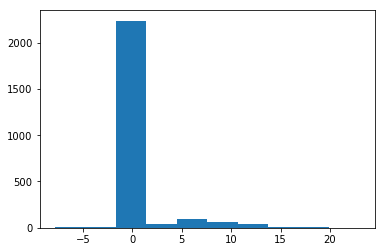

In [35]:
plt.hist(sess.run(G_sample, feed_dict=feed_dict))

In [ ]:
batch_sched

Training epoch 0
Iter: 0
D loss: 1.386
G_loss: 0.694
()


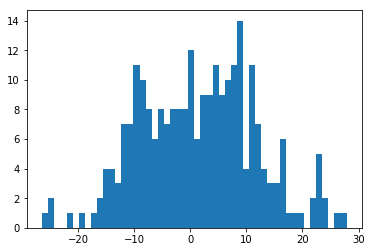

Training epoch 100
Training epoch 200
Training epoch 300
Training epoch 400
Training epoch 500
Training epoch 600
Training epoch 700
Training epoch 800
Training epoch 900
Training epoch 1000
Iter: 1000
D loss: 1.387
G_loss: 0.6938
()


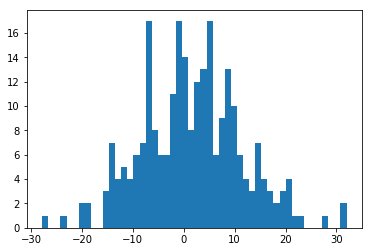

Training epoch 1100
Training epoch 1200
Training epoch 1300
Training epoch 1400
Training epoch 1500
Training epoch 1600
Training epoch 1700
Training epoch 1800
Training epoch 1900
Training epoch 2000
Iter: 2000
D loss: 1.386
G_loss: 0.6933
()


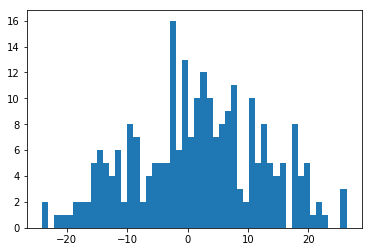

Training epoch 2100
Training epoch 2200
Training epoch 2300
Training epoch 2400
Training epoch 2500
Training epoch 2600
Training epoch 2700
Training epoch 2800
Training epoch 2900
Training epoch 3000
Iter: 3000
D loss: 1.387
G_loss: 0.693
()


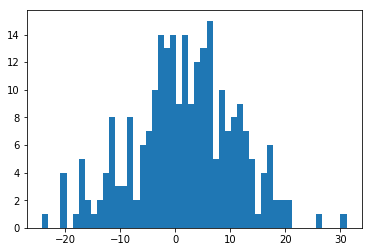

Training epoch 3100
Training epoch 3200
Training epoch 3300
Training epoch 3400
Training epoch 3500
Training epoch 3600
Training epoch 3700
Training epoch 3800
Training epoch 3900
Training epoch 4000
Iter: 4000
D loss: 1.386
G_loss: 0.6944
()


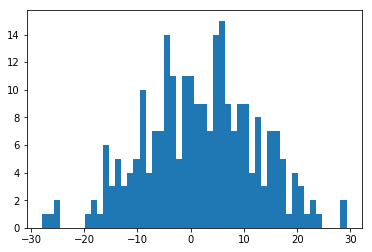

Training epoch 4100
Training epoch 4200
Training epoch 4300
Training epoch 4400
Training epoch 4500
Training epoch 4600
Training epoch 4700
Training epoch 4800
Training epoch 4900
Training epoch 5000
Iter: 5000
D loss: 1.386
G_loss: 0.6919
()


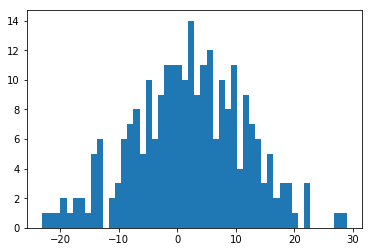

Training epoch 5100
Training epoch 5200
Training epoch 5300
Training epoch 5400
Training epoch 5500
Training epoch 5600
Training epoch 5700
Training epoch 5800
Training epoch 5900
Training epoch 6000
Iter: 6000
D loss: 1.386
G_loss: 0.6921
()


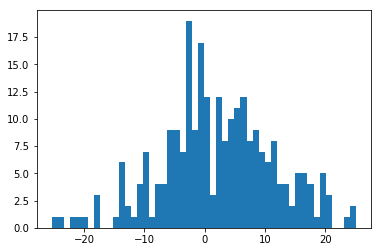

Training epoch 6100
Training epoch 6200
Training epoch 6300
Training epoch 6400
Training epoch 6500
Training epoch 6600
Training epoch 6700
Training epoch 6800
Training epoch 6900
Training epoch 7000
Iter: 7000
D loss: 1.386
G_loss: 0.6941
()


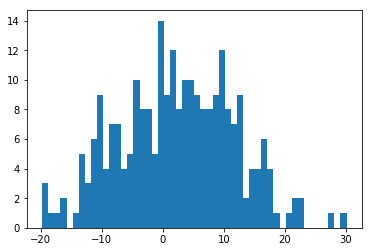

Training epoch 7100
Training epoch 7200
Training epoch 7300
Training epoch 7400
Training epoch 7500
Training epoch 7600
Training epoch 7700
Training epoch 7800
Training epoch 7900
Training epoch 8000
Iter: 8000
D loss: 1.386
G_loss: 0.6937
()


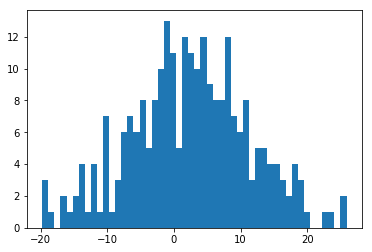

Training epoch 8100
Training epoch 8200
Training epoch 8300
Training epoch 8400
Training epoch 8500
Training epoch 8600
Training epoch 8700
Training epoch 8800
Training epoch 8900
Training epoch 9000
Iter: 9000
D loss: 1.386
G_loss: 0.6964
()


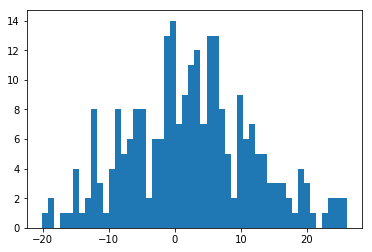

Training epoch 9100
Training epoch 9200
Training epoch 9300
Training epoch 9400
Training epoch 9500
Training epoch 9600
Training epoch 9700
Training epoch 9800
Training epoch 9900
Training epoch 10000
Iter: 10000
D loss: 1.385
G_loss: 0.6951
()


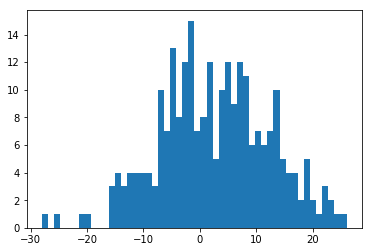

Training epoch 10100
Training epoch 10200
Training epoch 10300
Training epoch 10400
Training epoch 10500
Training epoch 10600
Training epoch 10700
Training epoch 10800
Training epoch 10900
Training epoch 11000
Iter: 11000
D loss: 1.387
G_loss: 0.6953
()


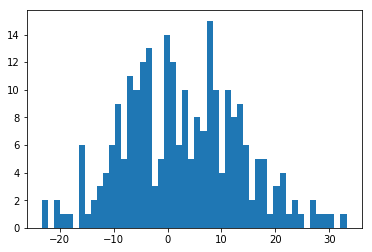

Training epoch 11100
Training epoch 11200
Training epoch 11300
Training epoch 11400
Training epoch 11500
Training epoch 11600
Training epoch 11700
Training epoch 11800
Training epoch 11900
Training epoch 12000
Iter: 12000
D loss: 1.386
G_loss: 0.691
()


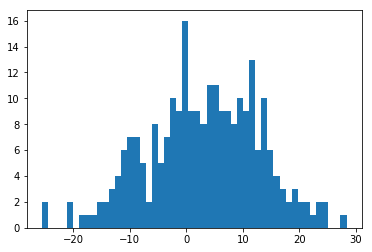

Training epoch 12100
Training epoch 12200
Training epoch 12300
Training epoch 12400
Training epoch 12500
Training epoch 12600
Training epoch 12700
Training epoch 12800
Training epoch 12900
Training epoch 13000
Iter: 13000
D loss: 1.387
G_loss: 0.6959
()


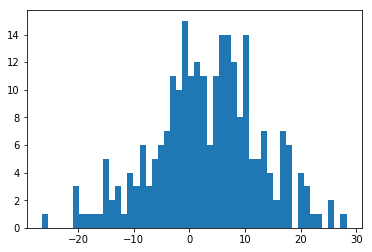

Training epoch 13100
Training epoch 13200
Training epoch 13300
Training epoch 13400
Training epoch 13500
Training epoch 13600
Training epoch 13700
Training epoch 13800
Training epoch 13900
Training epoch 14000
Iter: 14000
D loss: 1.389
G_loss: 0.6942
()


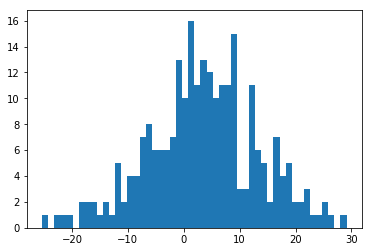

Training epoch 14100
Training epoch 14200
Training epoch 14300
Training epoch 14400
Training epoch 14500
Training epoch 14600
Training epoch 14700
Training epoch 14800
Training epoch 14900
Training epoch 15000
Iter: 15000
D loss: 1.385
G_loss: 0.6998
()


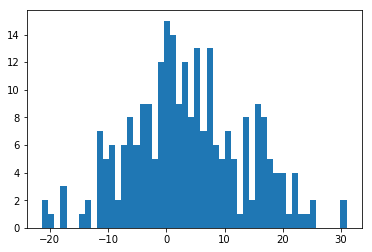

Training epoch 15100
Training epoch 15200
Training epoch 15300
Training epoch 15400
Training epoch 15500
Training epoch 15600
Training epoch 15700
Training epoch 15800
Training epoch 15900
Training epoch 16000
Iter: 16000
D loss: 1.385
G_loss: 0.6898
()


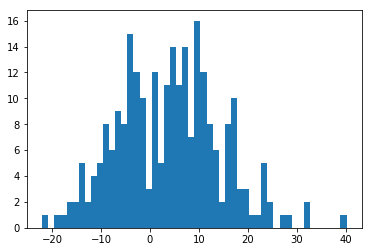

Training epoch 16100
Training epoch 16200
Training epoch 16300
Training epoch 16400
Training epoch 16500
Training epoch 16600
Training epoch 16700
Training epoch 16800
Training epoch 16900
Training epoch 17000
Iter: 17000
D loss: 1.386
G_loss: 0.6959
()


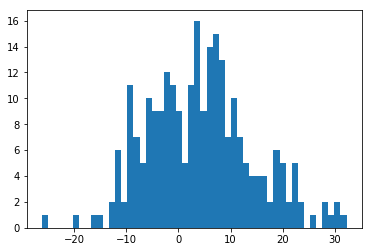

Training epoch 17100
Training epoch 17200
Training epoch 17300
Training epoch 17400
Training epoch 17500
Training epoch 17600
Training epoch 17700
Training epoch 17800
Training epoch 17900
Training epoch 18000
Iter: 18000
D loss: 1.388
G_loss: 0.6941
()


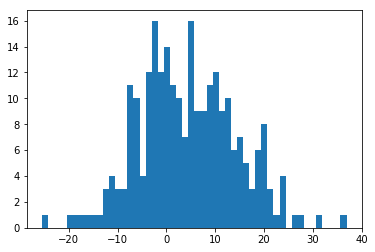

Training epoch 18100
Training epoch 18200
Training epoch 18300
Training epoch 18400
Training epoch 18500
Training epoch 18600
Training epoch 18700
Training epoch 18800
Training epoch 18900
Training epoch 19000
Iter: 19000
D loss: 1.386
G_loss: 0.6934
()


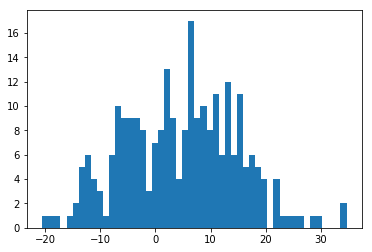

Training epoch 19100
Training epoch 19200
Training epoch 19300
Training epoch 19400
Training epoch 19500
Training epoch 19600
Training epoch 19700
Training epoch 19800
Training epoch 19900
Training epoch 20000
Iter: 20000
D loss: 1.385
G_loss: 0.6924
()


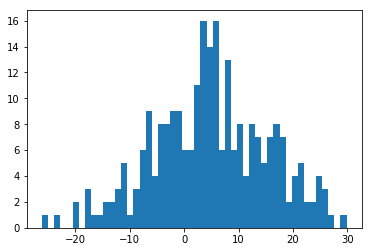

In [28]:
for it in range(20001):
    if it % 100 == 0:
        print("Training epoch %d" %it)
    batch_sched = list(range(0, n_train+1,S))
    for j in range(0, len(batch_sched)-1):
        start = batch_sched[j]
        stop = batch_sched[j+1]
        feed_dict = construct_feed_dict(train_dataset, start, stop)

        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict=feed_dict)

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict=feed_dict)
        plt.hist(samples, bins=50)
        plt.show()


In [112]:
preds = []
for k in range(0,100):
    feed_dict = construct_feed_dict(train_dataset, 0, 1)
    samples = sess.run(G_sample, feed_dict=feed_dict)[2]
    preds.append(samples)

(array([  9.,  11.,   8.,  13.,   6.,   8.,  12.,  13.,   7.,  13.]),
 array([ 0.03699268,  0.34541099,  0.65382929,  0.9622476 ,  1.27066591,
         1.57908422,  1.88750253,  2.19592084,  2.50433915,  2.81275746,
         3.12117577]),
 <a list of 10 Patch objects>)

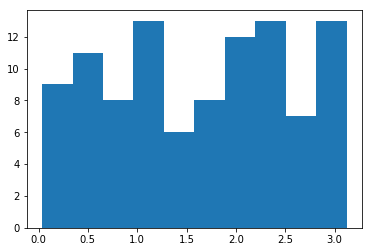

In [113]:
plt.hist(np.concatenate(preds))

In [98]:
preds[4]

array([ 2.70355487], dtype=float32)

In [93]:
train_dataset[0][1][1].toarray()

array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [43]:
res = gan.predict()

In [44]:
res

array([[  8.26161671],
       [ 18.00482559],
       [ 14.10464096],
       ..., 
       [ 21.83512688],
       [ 14.42951775],
       [ 21.71645737]], dtype=float32)

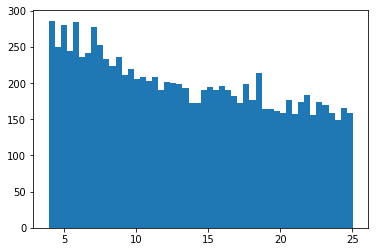

In [45]:
plt.hist(res, bins=50)
plt.show()

In [30]:
features[0][1][1].toarray()

array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [43]:
features[0][1][1].toarray()

array([[ 0.91292151],
       [ 3.09695411],
       [ 1.06725919],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0

In [12]:
preds = []
for i in range(0,100):
    preds.append(gan.predict(features)[0][2])

In [13]:
np.mean(preds)

12.944489

In [ ]:
features[0][2].atom_features